# Objectives

A supermarket aim is to boost marketing to increase their revenue.

We will perform RFM Analysis (Recency, Frequency, Monetary) to help determine customer cohort/group and how to treat each groups to help increase the revenue.

In [1]:
# Import library
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [2]:
# Read and preview Data
df = pd.read_csv('/Users/haribudiarto/Documents/Works/Data Works/sample_superstore.csv')
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/16,11/11/16,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/16,11/11/16,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/16,6/16/16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/15,10/18/15,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/15,10/18/15,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [16]:
# Filter only columns that will be used on RFM analysis
df_rfm = df[['Order ID','Order Date','Customer ID','Sales']]
df_rfm.rename(columns={'Order ID': 'order_id', 'Order Date': 'order_date', 
                       'Customer ID': 'customer_id','Sales':'sales'},inplace=True)
df_rfm.dtypes

/var/folders/x7/swz5z1hs37jdd940j2y7ffhh0000gn/T/ipykernel_1336/1228897822.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rfm.rename(columns={'Order ID': 'order_id', 'Order Date': 'order_date',


order_id        object
order_date      object
customer_id     object
sales          float64
dtype: object

In [17]:
# Change dtypes into datetime
df_rfm['order_date'] = pd.to_datetime(df_rfm['order_date'])
df_rfm.dtypes

/var/folders/x7/swz5z1hs37jdd940j2y7ffhh0000gn/T/ipykernel_1336/1875546073.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rfm['order_date'] = pd.to_datetime(df_rfm['order_date'])


order_id               object
order_date     datetime64[ns]
customer_id            object
sales                 float64
dtype: object

In [24]:
# Checking NA
df_rfm.isna().sum()

order_id       0
order_date     0
customer_id    0
sales          0
dtype: int64

In [19]:
# Determine Snapshot Date for Recency Calculation
print('Min Booking Date:',df_rfm.order_date.dt.date.min(),'max Booking Date:',
       df_rfm.order_date.dt.date.max())

snapshot_date = df_rfm['order_date'].max() + dt.timedelta(days=1)

Min Booking Date: 2014-01-03 max Booking Date: 2017-12-30


In [21]:
# Grouping by customer id
rfm = df_rfm.groupby(['customer_id']).agg({'order_date': lambda x : (snapshot_date - x.max()).days,
                                       'order_id':'count',
                                       'sales': 'sum'})

#Rename columns
rfm.rename(columns={'order_date':'Recency','order_id':'Frequency','sales':'MonetaryValue'}
           ,inplace= True)

#Final RFM values
rfm.head()

,Recency,Frequency,MonetaryValue
customer_id,,,
AA-10315,185,11,5563.560
AA-10375,20,15,1056.390
AA-10480,260,12,1790.512
AA-10645,56,18,5086.935
AB-10015,416,6,886.156


In [25]:
# Checking assumption before implement k-means

rfm_rfm = rfm[['Recency','Frequency','MonetaryValue']]
print(rfm_rfm.describe())

           Recency   Frequency  MonetaryValue
count   793.000000  793.000000     793.000000
mean    147.802018   12.602774    2896.848500
std     186.211051    6.242559    2628.670117
min       1.000000    1.000000       4.833000
25%      31.000000    8.000000    1146.050000
50%      76.000000   12.000000    2256.394000
75%     184.000000   16.000000    3785.276000
max    1166.000000   37.000000   25043.050000


In [26]:
# Since mean and stddev for each metrics is at different scale, we perform log transformation

# Log transformation
rfm_log = rfm[['Recency', 'Frequency', 'MonetaryValue']].apply(np.log, axis = 1).round(3)

# Normalize the variables with StandardScaler
scaler = StandardScaler()
scaler.fit(rfm_log)

#Store it separately for clustering
rfm_normalized = scaler.transform(rfm_log)

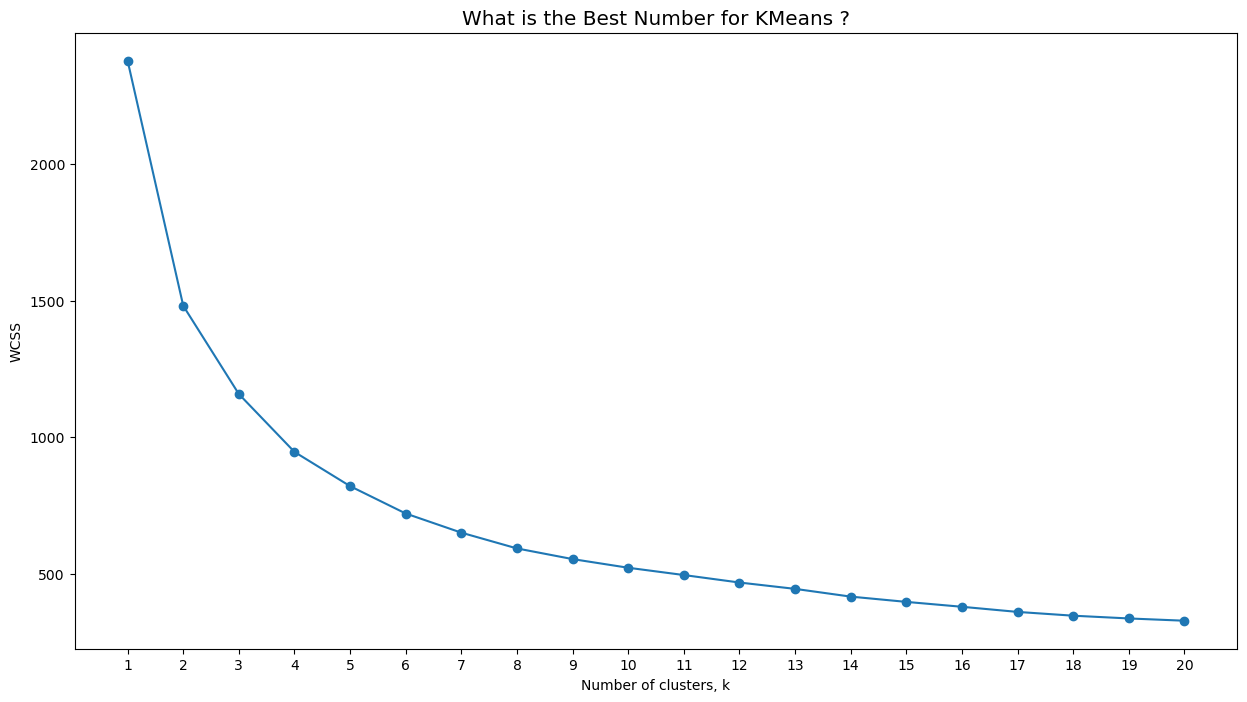

In [27]:
# Find the best cluster number with elbow method
kmeans = range(1,21)
wcss=[]
for k in kmeans :
    # Create a KMeans clusters
    kc = KMeans(n_clusters=k,random_state=21,n_init=10)
    kc.fit(rfm_normalized)
    wcss.append(kc.inertia_)

# Elbow plot
f, ax = plt.subplots(figsize=(15, 8))
plt.plot(kmeans, wcss, '-o')
plt.xlabel('Number of clusters, k')
plt.ylabel('WCSS')
plt.xticks(kmeans)
plt.style.use('ggplot')
plt.title('What is the Best Number for KMeans ?')
plt.show()

In [28]:
# From the plot above, decided to divide into 4 clusters
kc = KMeans(n_clusters= 4, random_state=21,n_init=10)
kc.fit(rfm_normalized)

cluster_labels = kc.labels_
rfm_rfm_k4 = rfm_rfm.assign(k_cluster = cluster_labels)

In [30]:
# Rearrange cluster alias by recency
replace_dict = {0:2,1:4,2:1,4:3}
rfm_rfm_k4['k_cluster'] = rfm_rfm_k4['k_cluster'].replace(replace_dict)

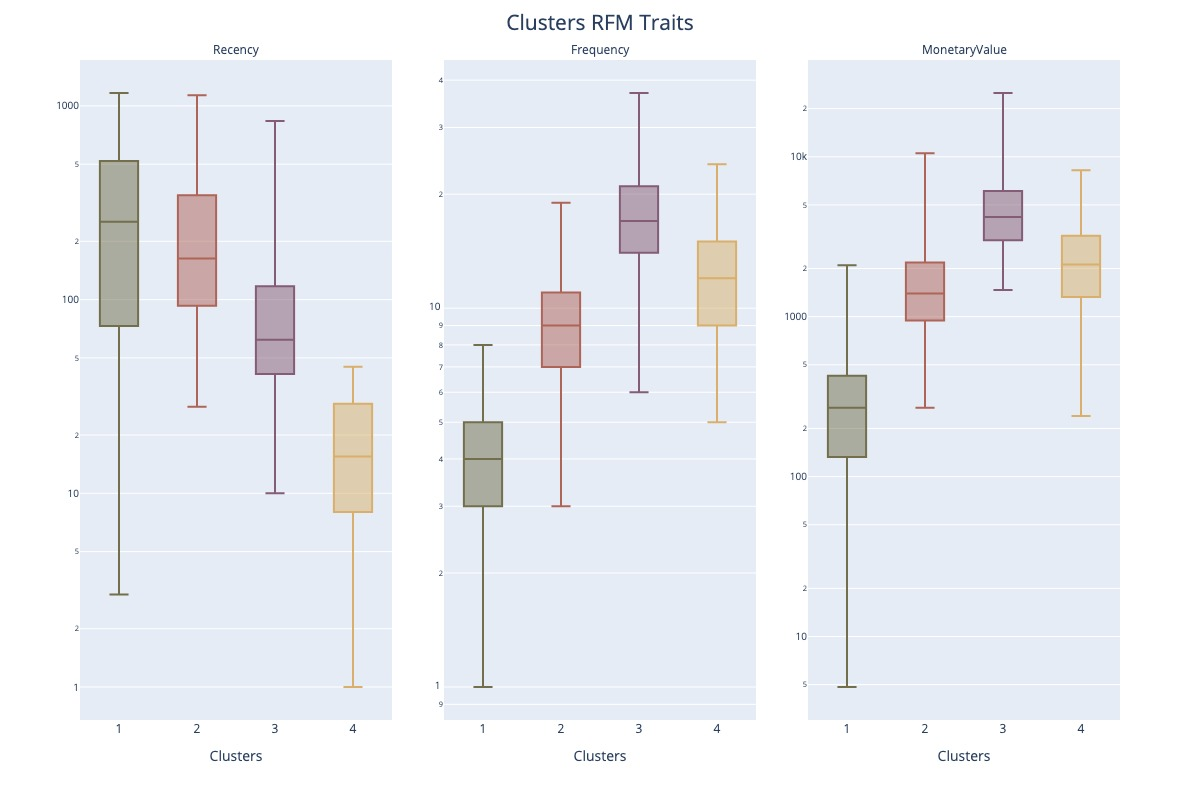

In [33]:
# Visualize RFM traits for each cluster
rfm_k4_melt = pd.melt(rfm_rfm_k4, id_vars='k_cluster', value_vars=['Recency', 'Frequency', 'MonetaryValue'],
var_name='metric',value_name='value')

fig = px.box(rfm_k4_melt, x='k_cluster',y='value',color='k_cluster',facet_col='metric',
             facet_col_spacing=0.05,color_discrete_sequence=px.colors.qualitative.Antique,
             width=1000,height=700)


fig.update_layout(showlegend=False,title_x=0.5,
                  title=dict(text="Clusters RFM Traits", font=dict(size=21)))

fig.update_xaxes(title_text='Clusters')
fig.update_yaxes(matches=None, title_text='', type='log',)
fig.for_each_yaxis(lambda yaxis: yaxis.update(showticklabels=True,tickfont=dict(size=10)))

fig.update_traces(boxpoints=False)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[1]))

fig.show('jpg',width=1200,height=800)

# ANALYSIS RESULT

After analyzing, we divide customers into 4 groups. Here are their characteristics and possible marketing treatment for each group.


Cluster 1 = Dormant Spenders
- Characteristics: High Recency, Low Frequency, Low Monetary
- Treatment idea like Win-Back Campaign = Send personalized emails or messages with special offers or discounts to entice them to make a purchase. Emphasize the benefits of your products or services and remind them of their past positive experiences.



Cluster 2 = At-Risk Customers
- Characteristics: High Recency, Med Frequency, Med Monetary
- Treatment idea like Re-Engagement Campaign = Create targeted content that highlights new or improved products/services, features, or updates. Offer them an incentive to come back, like a loyalty discount or a limited-time offer.


Cluster 3 = VIP Customers
- Characteristics: Med Recency, High Frequency, High Monetary
- Treatment idea like Exclusive Offers = Recognize their loyalty by providing exclusive offers, early access to new products, or VIP events. Consider implementing a loyalty rewards program to further incentivize their frequent purchases.


Cluster 4 = Active High-Value Customers
- Characteristics: Low Recency, High Frequency, High Monetary
- Treatment idea like Upsell and Cross-Sell Campaign: Recommend complementary products or premium versions of what they're already purchasing. Create bundles or packages to showcase the value they can receive by spending more.